In [11]:
from cheatsheet import CHEATSHEETS
from prompt import PROMPTS
PROMPTS["DEFAULT_ENTITY_TYPES"]
                   

['Metadata date',
 'Metadata language',
 'Responsible organization metadata',
 'Landing page',
 'Title',
 'description',
 'Unique Identifier',
 'Resource type',
 'Keywords',
 'Data creator',
 'Data contact point',
 'Data publisher',
 'Spatial coverage',
 'Spatial resolution',
 'Spatial reference system',
 'Temporal coverage',
 'Temporal resolution',
 'License',
 'Access rights',
 'Distribution access URL',
 'Distribution format',
 'Distribution byte size']

In [13]:
from dataclasses import dataclass
from typing import Optional

@dataclass
class MetadataFields:
    metadata_date: Optional[str] = None
    metadata_language: Optional[str] = None
    responsible_organization_metadata: Optional[str] = None
    landing_page: Optional[str] = None
    title: Optional[str] = None
    description: Optional[str] = None
    unique_identifier: Optional[str] = None
    resource_type: Optional[str] = None
    keywords: Optional[str] = None
    data_creator: Optional[str] = None
    data_contact_point: Optional[str] = None
    data_publisher: Optional[str] = None
    spatial_coverage: Optional[str] = None
    spatial_resolution: Optional[str] = None
    spatial_reference_system: Optional[str] = None
    temporal_coverage: Optional[str] = None
    temporal_resolution: Optional[str] = None
    license: Optional[str] = None
    access_rights: Optional[str] = None
    distribution_access_url: Optional[str] = None
    distribution_format: Optional[str] = None
    distribution_byte_size: Optional[str] = None

# Example usage:
metadata = MetadataFields()
# To set values:
metadata.metadata_date = "T"
metadata.metadata_language = "F"
# etc.

In [ ]:
def convert_field_name(field_name: str) -> str:
    """Convert field name from text format to attribute format"""
    # Remove colon if present and convert to lowercase
    field_name = field_name.rstrip(':').lower()
    # Replace spaces with underscores
    return field_name.replace(' ', '_')

def extract_indicators(text):
    """
    Extract indicators (- T, - F, - ?) from field values in the text.
    
    Args:
        text (str): Input text containing metadata fields and their indicators
        
    Returns:
        dict: Dictionary with source URLs as keys and MetadataFields objects as values
    """
    label_dict = {}
    current_field = None
    current_url = None
    metadata = MetadataFields()
    
    for line in text.split('\n'):
        line = line.strip()
        
        # Handle Source URL
        if line.startswith('Source URL:'):
            if current_url and metadata:
                label_dict[current_url] = metadata
                metadata = MetadataFields()
            current_url = line.replace('Source URL:', '').strip()
            continue
        
        # Skip separator lines and empty lines
        if line.startswith('===') or not line:
            continue
            
        # If line ends with colon, it's a field name
        if line.endswith(':'):
            current_field = convert_field_name(line)
            continue
            
        # If line starts with dash, it contains an indicator
        if line.startswith('-'):
            if current_field and hasattr(metadata, current_field):
                if 'T' in line[-2:]:  # Check for T in last 2 chars
                    setattr(metadata, current_field, 'T')
                elif 'F' in line[-2:]:  # Check for F in last 2 chars
                    setattr(metadata, current_field, 'F')
                elif '?' in line[-2:]:  # Check for ? in last 2 chars
                    setattr(metadata, current_field, '?')
    
    # Add the last metadata object if it exists
    if current_url and metadata:
        label_dict[current_url] = metadata
                
    return label_dict

# Example usage
sample_text = """==================================================
Source URL: https://stac.ecodatacube.eu/blue_glad.landsat.ard2.seasconv.m.yearly/collection.json

==================================================
Metadata date:
  - (EcoDataCube, The metadata date is not explicitly mentioned in the text.)
  - T
"""

result = extract_indicators(sample_text)
print(result)

{'https://stac.ecodatacube.eu/blue_glad.landsat.ard2.seasconv.m.yearly/collection.json': MetadataFields(metadata_date='T', metadata_language=None, responsible_organization_metadata=None, landing_page=None, title=None, description=None, unique_identifier=None, resource_type=None, keywords=None, data_creator=None, data_contact_point=None, data_publisher=None, spatial_coverage=None, spatial_resolution=None, spatial_reference_system=None, temporal_coverage=None, temporal_resolution=None, license=None, access_rights=None, distribution_access_url=None, distribution_format=None, distribution_byte_size=None)}


In [26]:
with open('outputs/entity_annotation.txt', 'r') as f:
    sample_text = f.read()

result = extract_indicators(sample_text)
print(result)

{'https://lifesciences.datastations.nl/dataset.xhtml?persistentId=doi:10.17026/dans-2bd-kskz': MetadataFields(metadata_date='T', metadata_language='T', responsible_organization_metadata='T', landing_page='T', title='T', description='?', unique_identifier='T', resource_type=None, keywords='T', data_creator='T', data_contact_point='?', data_publisher='?', spatial_coverage='T', spatial_resolution='T', spatial_reference_system='T', temporal_coverage='T', temporal_resolution='T', license='T', access_rights=None, distribution_access_url='F', distribution_format='T', distribution_byte_size='?'), 'https://www.gbif.org/dataset/4fa7b334-ce0d-4e88-aaae-2e0c138d049e': MetadataFields(metadata_date='T', metadata_language='T', responsible_organization_metadata='T', landing_page='T', title='T', description='T', unique_identifier='T', resource_type='?', keywords='T', data_creator='?', data_contact_point='T', data_publisher='T', spatial_coverage='F', spatial_resolution='T', spatial_reference_system='T',

In [ ]:
def calculate_overall_stats(results: dict) -> dict:
    """Calculate overall statistics for all datasets"""
    total_fields = 0
    counts = {'T': 0, 'F': 0, '?': 0, 'Missing': 0}
    
    for metadata in results.values():
        for value in vars(metadata).values():
            total_fields += 1
            if value in counts:
                counts[value] += 1
            else:
                counts['Missing'] += 1
    
    percentages = {
        key: (count / total_fields * 100) if total_fields > 0 else 0 
        for key, count in counts.items()
    }
    
    return {
        'counts': counts,
        'percentages': percentages,
        'total_fields': total_fields
    }

def calculate_dataset_stats(results: dict) -> dict:
    """Calculate statistics for each dataset"""
    dataset_stats = {}
    
    for url, metadata in results.items():
        counts = {'T': 0, 'F': 0, '?': 0, 'Missing': 0}
        total = 0
        
        for value in vars(metadata).values():
            total += 1
            if value in counts:
                counts[value] += 1
            else:
                counts['Missing'] += 1
        
        dataset_stats[url] = {
            'counts': counts,
            'percentages': {
                key: (count / total * 100) if total > 0 else 0 
                for key, count in counts.items()
            },
            'total_fields': total
        }
    
    return dataset_stats

def calculate_attribute_stats(results: dict) -> dict:
    """Calculate statistics for each metadata attribute"""
    attribute_stats = {}
    
    # Initialize counters for each attribute
    for field in vars(next(iter(results.values()))).keys():
        attribute_stats[field] = {'T': 0, 'F': 0, '?': 0, 'Missing': 0}
    
    # Count occurrences
    total_datasets = len(results)
    for metadata in results.values():
        for field, value in vars(metadata).items():
            if value in attribute_stats[field]:
                attribute_stats[field][value] += 1
            else:
                attribute_stats[field]['Missing'] += 1
    
    # Calculate percentages
    for field in attribute_stats:
        attribute_stats[field]['percentages'] = {
            key: (count / total_datasets * 100) 
            for key, count in attribute_stats[field].items() 
            if key != 'percentages'
        }
    
    return attribute_stats

# Calculate and print all statistics
def print_all_stats(results: dict):
    """Print all statistics in a readable format"""
    
    print("1. Overall Statistics:")
    overall_stats = calculate_overall_stats(results)
    print(f"Total fields analyzed: {overall_stats['total_fields']}")
    print("Percentages:")
    for key, value in overall_stats['percentages'].items():
        print(f"  {key}: {value:.2f}%")
    
    print("\n2. Dataset Statistics:")
    dataset_stats = calculate_dataset_stats(results)
    for url, stats in dataset_stats.items():
        print(f"\nDataset: {url}")
        print("Percentages:")
        for key, value in stats['percentages'].items():
            print(f"  {key}: {value:.2f}%")
    
    print("\n3. Attribute Statistics:")
    attribute_stats = calculate_attribute_stats(results)
    for field, stats in attribute_stats.items():
        print(f"\n{field}:")
        print("Percentages:")
        for key, value in stats['percentages'].items():
            print(f"  {key}: {value:.2f}%")

# Use this with your results
print_all_stats(result)

1. Overall Statistics:


KeyError: 'None'

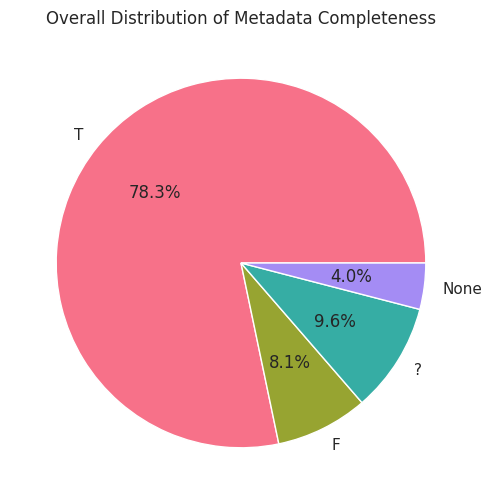

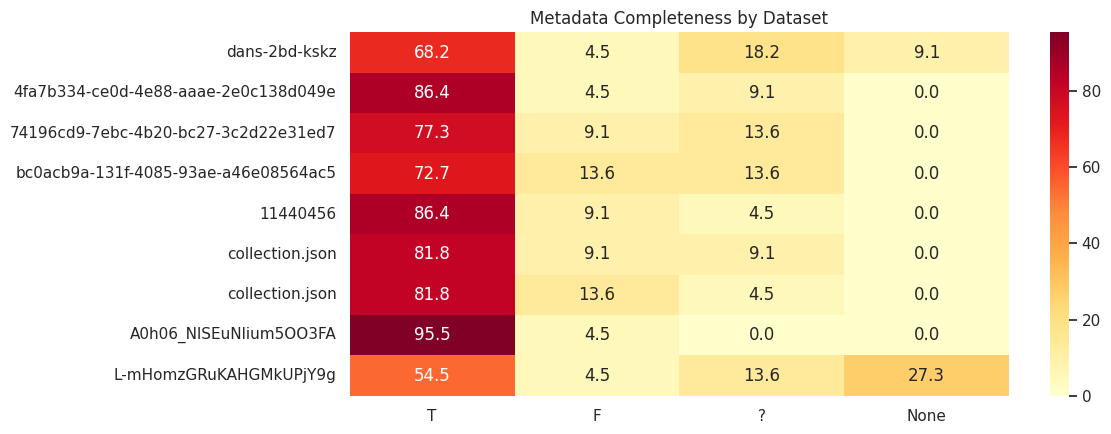

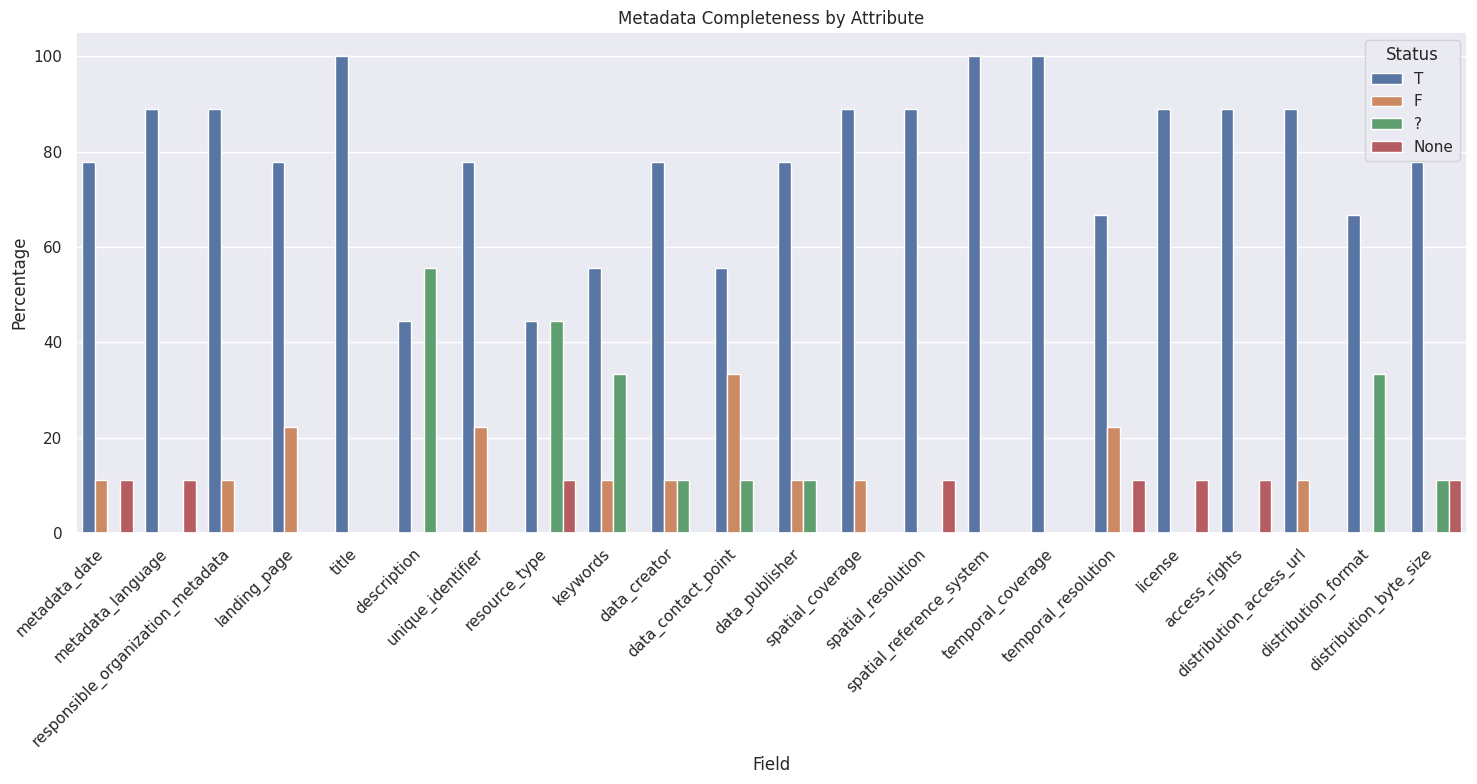

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_statistics(results: dict):
    """Create visualizations for metadata statistics"""
    # Set style to a built-in matplotlib style
    plt.style.use('default')
    
    # Set figure aesthetics
    sns.set_theme()
    
    # 1. Overall Statistics Pie Chart
    plt.figure(figsize=(10, 6))
    overall_stats = calculate_overall_stats(results)
    colors = sns.color_palette('husl', n_colors=len(overall_stats['percentages']))
    plt.pie(overall_stats['percentages'].values(), 
            labels=overall_stats['percentages'].keys(),
            autopct='%1.1f%%',
            colors=colors)
    plt.title('Overall Distribution of Metadata Completeness')
    plt.show()
    
    # 2. Dataset Statistics Heatmap
    dataset_stats = calculate_dataset_stats(results)
    dataset_data = []
    for url, stats in dataset_stats.items():
        row = stats['percentages']
        row['URL'] = url
        dataset_data.append(row)
    
    df_datasets = pd.DataFrame(dataset_data)
    plt.figure(figsize=(12, len(dataset_data) * 0.5))
    sns.heatmap(df_datasets.drop('URL', axis=1), 
                annot=True, 
                fmt='.1f',
                cmap='YlOrRd',
                yticklabels=[url.split('/')[-1] for url in df_datasets['URL']])
    plt.title('Metadata Completeness by Dataset')
    plt.tight_layout()
    plt.show()
    
    # 3. Attribute Statistics Bar Chart
    attribute_stats = calculate_attribute_stats(results)
    attr_data = []
    for field, stats in attribute_stats.items():
        row = stats['percentages']
        row['Field'] = field
        attr_data.append(row)
    
    df_attrs = pd.DataFrame(attr_data)
    
    plt.figure(figsize=(15, 8))
    df_attrs_melted = df_attrs.melt(id_vars=['Field'], 
                                   var_name='Status', 
                                   value_name='Percentage')
    
    sns.barplot(data=df_attrs_melted, 
                x='Field', 
                y='Percentage', 
                hue='Status')
    plt.xticks(rotation=45, ha='right')
    plt.title('Metadata Completeness by Attribute')
    plt.tight_layout()
    plt.show()

# First make sure required packages are imported
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Use this to create the plots
plot_statistics(result)